In [2]:
cd ..

/home/uniq/Documents/Deep Learning/VANILLA GAN


# GAN Training on a Face Dataset
This notebook trains a simple DCGAN-like architecture on a custom face dataset.

## Steps
1. Import libraries
2. Create a custom dataset and apply transformations
3. Define the Discriminator and Generator architectures
4. Train the GAN
5. Visualize generated samples

Note:
- This code uses label smoothing for the Discriminator.
- The dataset is assumed to be images of shape 64×64.
- Make sure the path `img_path = './data/Male and Female face dataset'` matches your local structure.


In [3]:
%matplotlib inline
import os
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


## Hyperparameters

In [4]:
lr = 0.001
batch_size = 64
num_epochs = 10
img_path = './data/Male and Female face dataset'  # <-- Adjust this path to your dataset

# A few more constants
#   - We'll use 64x64 images, 3 channels
#   - We'll generate a 100-dimensional latent vector
z_dim = 100

## Data Transformation
We apply simple transforms:
- Resize to (64,64)
- Convert to Tensor
- Normalize to [-1,1]


In [5]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # Resize to 64x64
    transforms.CenterCrop(64),    # Crop if needed (often redundant if resize is exact)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1,1]
])

## Custom Dataset
We'll collect all image paths from the specified directory. Our dataset will return **only** the image (no label).

In [6]:
class FaceDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.image_paths = []

        # Collect all image paths
        for subdir, _, files in os.walk(img_path):
            for file in files:
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.image_paths.append(os.path.join(subdir, file))

        print(f"Found {len(self.image_paths)} images in {img_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

### Create dataset and dataloader

In [7]:
face_data = FaceDataset(img_path, transform=transform)
face_dataloader = DataLoader(face_data, batch_size=batch_size, shuffle=True)

# Quick test
batch = next(iter(face_dataloader))
print("Batch shape:", batch.shape)  # [B, C, H, W]

Found 5418 images in ./data/Male and Female face dataset
Batch shape: torch.Size([64, 3, 64, 64])


## Discriminator
A simple CNN that outputs a single probability (real/fake).

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            # input: (3, 64, 64)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Quick test on random data
D = Discriminator().to(device)
test_input = torch.randn(4, 3, 64, 64, device=device)
test_output = D(test_input)
print("Discriminator output shape:", test_output.shape)  # Should be [4, 1]

Discriminator output shape: torch.Size([4, 1])


## Generator
A simple transposed CNN that takes a latent vector (z_dim=100) and produces a (3,64,64) image.

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            # input: (z_dim, 1, 1)
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Quick test
G = Generator(z_dim=z_dim).to(device)
test_noise = torch.randn(4, 100, 1, 1, device=device)
fake_images = G(test_noise)
print("Generator output shape:", fake_images.shape)  # Should be [4,3,64,64]

Generator output shape: torch.Size([4, 3, 64, 64])


## Loss and Optimizers

In [10]:
discriminator = Discriminator().to(device)
generator = Generator(z_dim=z_dim).to(device)

criterion = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


## Training Helpers

In [11]:
def train_discriminator(discriminator, real_images, fake_images, d_optimizer, criterion, device):
    """
    Train discriminator on both real and fake images.
    - Use label smoothing: real labels = 0.9, fake labels = 0.1
    """
    discriminator.train()
    d_optimizer.zero_grad()

    # Label smoothing
    real_labels = torch.full((len(real_images), 1), 0.9, device=device)
    fake_labels = torch.full((len(fake_images), 1), 0.1, device=device)

    # Discriminator forward pass on real
    real_preds = discriminator(real_images)
    real_loss = criterion(real_preds, real_labels)

    # Discriminator forward pass on fake
    fake_preds = discriminator(fake_images)
    fake_loss = criterion(fake_preds, fake_labels)

    # Total discriminator loss
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()

def train_generator(discriminator, fake_images, g_optimizer, criterion, device):
    """
    Train generator to fool the discriminator.
    - We want D(fake) -> 1.
    """
    generator.train()
    g_optimizer.zero_grad()

    # Labels for fake images that we want the discriminator to output
    target_labels = torch.ones(len(fake_images), 1, device=device)

    # Discriminator predictions on fake images
    preds = discriminator(fake_images)
    g_loss = criterion(preds, target_labels)
    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()

def generate_noise(batch_size, z_dim, device):
    return torch.randn(batch_size, z_dim, 1, 1, device=device)


## Visualization Helper

In [12]:
def visualize_samples(generator, device, num_samples=8, z_dim=100):
    generator.eval()
    noise_vec = generate_noise(num_samples, z_dim, device=device)
    with torch.no_grad():
        fake = generator(noise_vec).detach().cpu()

    # Denormalize from [-1,1] to [0,1]
    fake = (fake * 0.5) + 0.5

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        axes[i].imshow(fake[i].permute(1, 2, 0))  # (C,H,W)->(H,W,C)
        axes[i].axis('off')
    plt.show()

## Training Loop

Epoch 1/10: 100%|██████████| 85/85 [03:09<00:00,  2.23s/it]

Epoch [1/10] | D Loss: 82.6326 | G Loss: 435.9073


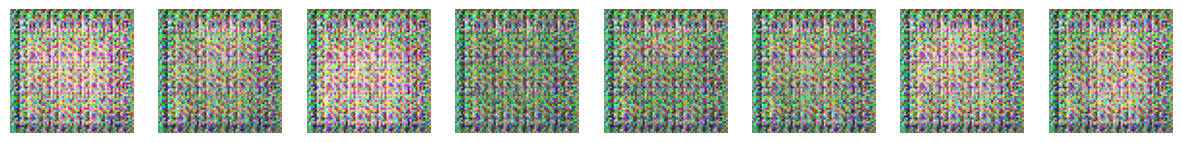

Epoch 2/10: 100%|██████████| 85/85 [03:05<00:00,  2.18s/it]

Epoch [2/10] | D Loss: 81.7355 | G Loss: 232.2767


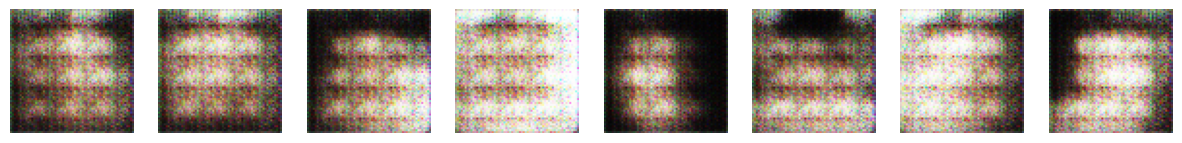

Epoch 3/10: 100%|██████████| 85/85 [03:09<00:00,  2.23s/it]

Epoch [3/10] | D Loss: 87.3581 | G Loss: 208.5186


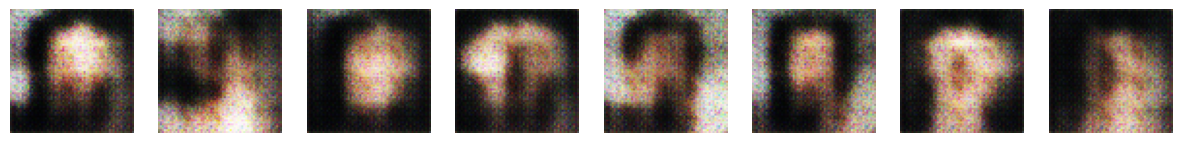

Epoch 4/10: 100%|██████████| 85/85 [03:19<00:00,  2.35s/it]

Epoch [4/10] | D Loss: 80.8859 | G Loss: 203.1420


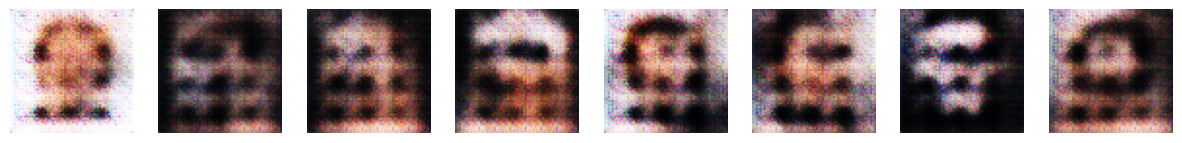

Epoch 5/10: 100%|██████████| 85/85 [03:11<00:00,  2.25s/it]

Epoch [5/10] | D Loss: 86.4031 | G Loss: 189.3304


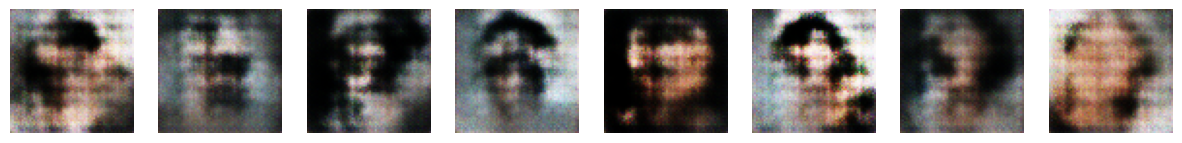

Epoch 6/10: 100%|██████████| 85/85 [03:13<00:00,  2.27s/it]


Epoch [6/10] | D Loss: 86.0820 | G Loss: 181.0187


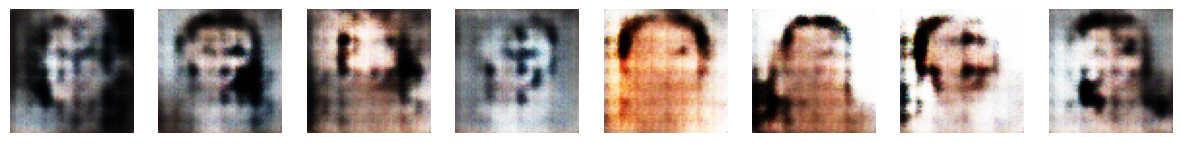

Epoch 7/10: 100%|██████████| 85/85 [03:12<00:00,  2.27s/it]

Epoch [7/10] | D Loss: 82.9956 | G Loss: 188.1332


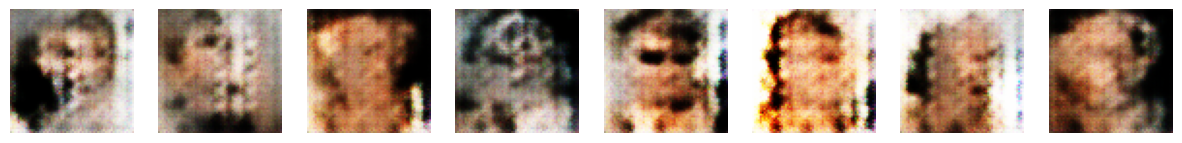

Epoch 8/10: 100%|██████████| 85/85 [03:24<00:00,  2.41s/it]

Epoch [8/10] | D Loss: 79.4602 | G Loss: 194.6492


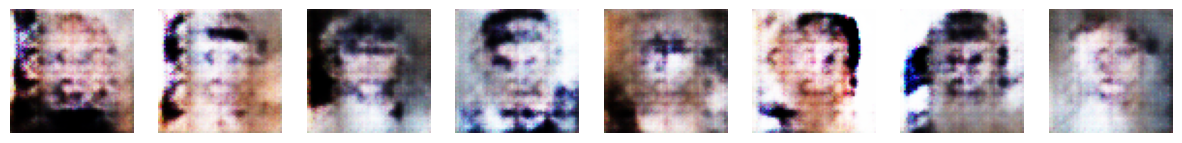

Epoch 9/10: 100%|██████████| 85/85 [03:19<00:00,  2.35s/it]

Epoch [9/10] | D Loss: 81.2250 | G Loss: 192.2754


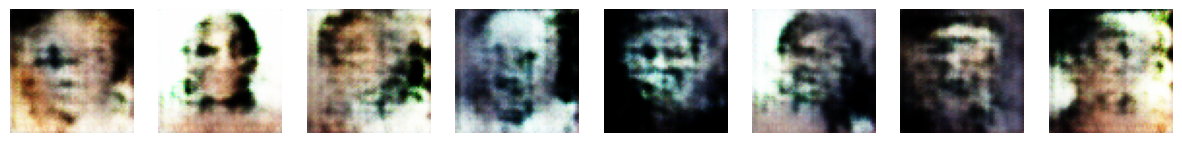

Epoch 10/10: 100%|██████████| 85/85 [03:15<00:00,  2.31s/it]


Epoch [10/10] | D Loss: 78.0990 | G Loss: 199.0449


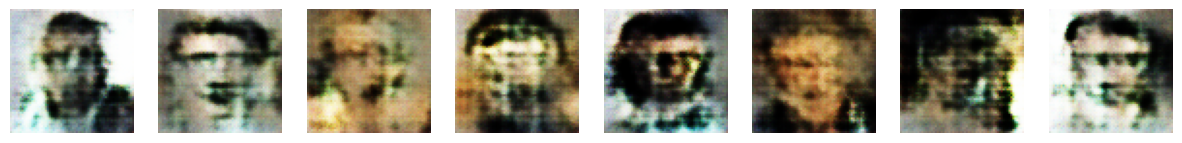

Training finished!


In [13]:
# If needed, re-initialize the models
# (Comment these out if you already defined them above)
# D = Discriminator().to(device)
# generator = Generator(z_dim).to(device)
# criterion = nn.BCELoss()
# d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

total_gen_loss = []
total_disc_loss = []

for epoch in range(1, num_epochs + 1):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0

    for real_images in tqdm(face_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        real_images = real_images.to(device)

        # 1) Train Discriminator
        # -----------------------
        # Generate fake images
        z = generate_noise(len(real_images), z_dim, device)
        fake_images = generator(z)

        # Update D
        disc_loss = train_discriminator(
            discriminator, real_images, fake_images,
            d_optimizer, criterion, device
        )

        # 2) Train Generator
        # -------------------
        # Generate new noise/fake images again
        z = generate_noise(len(real_images), z_dim, device)
        fake_images = generator(z)

        gen_loss = train_generator(
            discriminator, fake_images, g_optimizer,
            criterion, device
        )

        epoch_gen_loss += gen_loss
        epoch_disc_loss += disc_loss

    # Print losses
    print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {epoch_disc_loss:.4f} | G Loss: {epoch_gen_loss:.4f}")
    total_gen_loss.append(epoch_gen_loss)
    total_disc_loss.append(epoch_disc_loss)

    # Visualize samples each epoch
    visualize_samples(generator, device, num_samples=8, z_dim=z_dim)

print("Training finished!")

## Plot Loss Curves

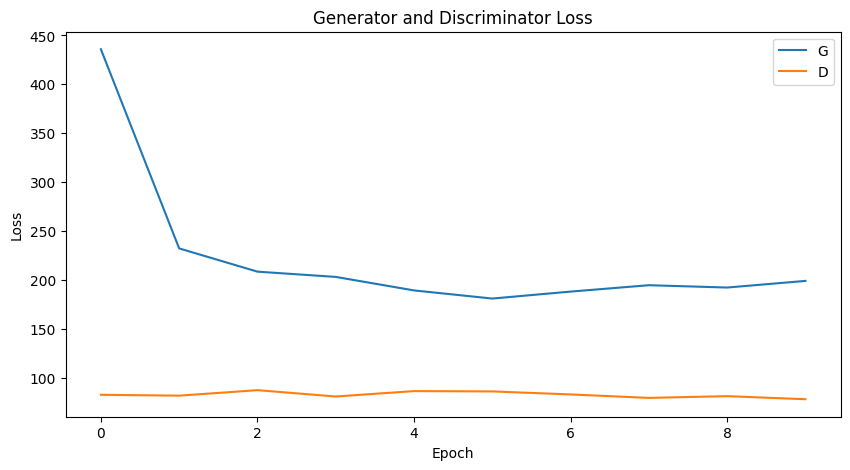

In [14]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss")
plt.plot(total_gen_loss, label="G")
plt.plot(total_disc_loss, label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Saving the Models
You can also save the trained models:
```python
torch.save(generator.state_dict(), 'DCgenerator.pth')
torch.save(discriminator.state_dict(), 'DCdiscriminator.pth')
```
Then later:
```python
G = Generator(z_dim=100)
G.load_state_dict(torch.load('DCgenerator.pth'))
```


In [15]:
torch.save(generator.state_dict(), 'DCgenerator.pth')
torch.save(discriminator.state_dict(), 'DCdiscriminator.pth')

In [16]:
G = Generator(z_dim=100)
G.load_state_dict(torch.load('DCgenerator.pth'))

/tmp/ipykernel_12985/1286417302.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('DCgenerator.pth'))


<All keys matched successfully>